In [3]:
import pandas as pd
import matplotlib.pyplot as plt


20:45:04 matplotlib data path: C:\Users\Chuon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\mpl-data
20:45:04 CONFIGDIR=C:\Users\Chuon\.matplotlib
20:45:04 interactive is False
20:45:04 platform is win32
20:45:05 CACHEDIR=C:\Users\Chuon\.matplotlib
20:45:05 Using fontManager instance from C:\Users\Chuon\.matplotlib\fontlist-v330.json


In [40]:
def load_and_plot_csv(csv_path, x_column, y_column, figsize=(10, 6), nrows=1, ncols=1):
    try:
        # Load CSV data into a DataFrame
        df = pd.read_csv(csv_path)

        # Display the first few rows of the DataFrame (optional)
        print("Data Preview:")
        print(df.head())

        # Create subplots
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

        # Plot the specific columns
        if nrows == 1 and ncols == 1:
            # Single plot
            df.plot(x=x_column, y=y_column, kind='line', title=f'Plot of {y_column} against {x_column}', ax=ax)
            ax.set_xlabel(f'{x_column} Axis Label')
            ax.set_ylabel(f'{y_column} Axis Label')
        else:
            # Multiple subplots
            for i in range(nrows):
                for j in range(ncols):
                    subset_df = df.sample(frac=1)  # Sample to get a subset of data
                    subset_df.plot(x=x_column, y=y_column, kind='line', title=f'Plot of {y_column} against {x_column}', ax=ax[i, j])
                    ax[i, j].set_xlabel(f'{x_column} Axis Label')
                    ax[i, j].set_ylabel(f'{y_column} Axis Label')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

Data Preview:
           Time(UTC+0)          Time(UTC+8)  Temp(°C)  RH(%)  PM2.5(μm/m^3)  \
0  2024/03/09 03:59:58  2024/03/09 11:59:58     31.28  60.06             62   
1  2024/03/09 03:59:48  2024/03/09 11:59:48     31.34  60.08             59   
2  2024/03/09 03:59:38  2024/03/09 11:59:38     31.30  60.08             57   
3  2024/03/09 03:59:27  2024/03/09 11:59:27     31.27  60.07             59   
4  2024/03/09 03:59:17  2024/03/09 11:59:17     31.27  60.16             60   

   CO2(ppm)  
0       502  
1       502  
2       503  
3       503  
4       503  


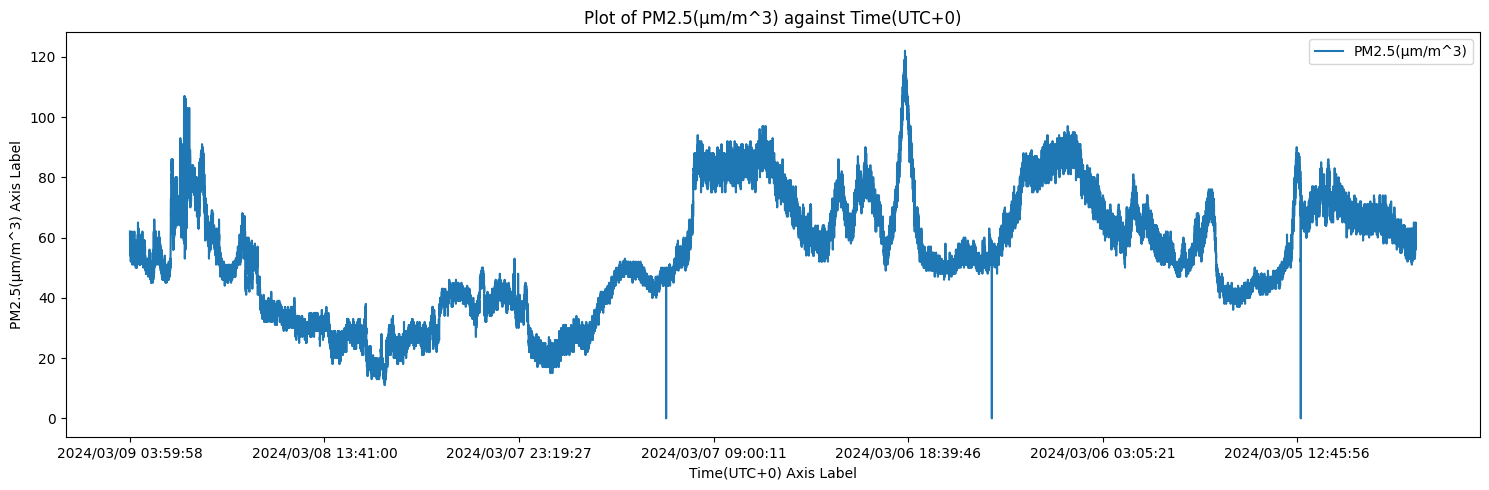

In [49]:

csv_path = '../data/data.csv'
x_column_to_plot = 'Time(UTC+0)'  # Check the case and spelling in your CSV file
y_column_to_plot = 'PM2.5(μm/m^3)'
load_and_plot_csv(csv_path, x_column_to_plot, y_column_to_plot, figsize=(15, 5), nrows=1, ncols=1)

In [5]:
import logging
import numpy as np
import pandas as pd
import sys  # Add this import statement

logging.basicConfig(datefmt='%H:%M:%S',
                    stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s %(message)s')

# Distance away from the FBEWMA that data should be removed.
DELTA = 0.1

# clip data above this value:
HIGH_CLIP = 2.1

# clip data below this value:
LOW_CLIP = -2.1

# random values above this trigger a spike:
RAND_HIGH = 0.98

# random values below this trigger a negative spike:
RAND_LOW = 0.02

# How many samples to run the FBEWMA over.
SPAN = 10

# spike amplitude
SPIKE = 2


def clip_data(unclipped, high_clip, low_clip):
    ''' Clip unclipped between high_clip and low_clip. 
    unclipped contains a single column of unclipped data.'''
    
    # convert to np.array to access the np.where method
    np_unclipped = np.array(unclipped)
    # clip data above HIGH_CLIP or below LOW_CLIP
    cond_high_clip = (np_unclipped > HIGH_CLIP) | (np_unclipped < LOW_CLIP)
    np_clipped = np.where(cond_high_clip, np.nan, np_unclipped)
    return np_clipped.tolist()


def create_sample_data():
    ''' Create sine wave, amplitude +/-2 with random spikes. '''
    x = np.linspace(0, 2*np.pi, 1000)
    y = 2 * np.sin(x)
    df = pd.DataFrame(list(zip(x,y)), columns=['x', 'y'])
    df['rand'] = np.random.random_sample(len(x),)
    # create random positive and negative spikes
    cond_spike_high = (df['rand'] > RAND_HIGH)
    df['spike_high'] = np.where(cond_spike_high, SPIKE, 0)
    cond_spike_low = (df['rand'] < RAND_LOW)
    df['spike_low'] = np.where(cond_spike_low, -SPIKE, 0)
    df['PM2.5(μm/m^3)'] = df['y'] + df['spike_high'] + df['spike_low']
    return df


def ewma_fb(df_column, span):
    ''' Apply forwards, backwards exponential weighted moving average (EWMA) to df_column. '''
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=10).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    return fb_ewma
    
    
def remove_outliers(spikey, fbewma, delta):
    ''' Remove data from df_spikey that is > delta from fbewma. '''
    np_spikey = np.array(spikey)
    np_fbewma = np.array(fbewma)
    cond_delta = (np.abs(np_spikey-np_fbewma) > delta)
    np_remove_outliers = np.where(cond_delta, np.nan, np_spikey)
    return np_remove_outliers

    
def main():
    # Read your CSV file
    csv_path = '../data/data.csv'  # Update with the actual path to your CSV file
    df = pd.read_csv(csv_path)

    df['rand'] = np.random.random_sample(len(df))

    df['y_clipped'] = clip_data(df['PM2.5(μm/m^3)'].tolist(), HIGH_CLIP, LOW_CLIP)
    df['y_ewma_fb'] = ewma_fb(df['y_clipped'], SPAN)
    df['y_remove_outliers'] = remove_outliers(df['y_clipped'].tolist(), df['y_ewma_fb'].tolist(), DELTA)
    df['y_interpolated'] = df['y_remove_outliers'].interpolate()

    # Plot the data
    plt.figure(figsize=(10, 6))

    df['Time(UTC+0)'] = pd.to_numeric(df['Time(UTC+0)'])

    plt.plot(df['Time(UTC+0)'], df['PM2.5(μm/m^3)'], color='blue', alpha=0.5, label='Original Data')
    plt.plot(df['Time(UTC+0)'], df['y_interpolated'], color='black', label='Interpolated Data')

    plt.title('Original Data and Interpolated Data')
    plt.xlabel('Time(UTC+0)')  # Update with the actual label for the x-axis
    plt.ylabel('PM2.5(μm/m^3)')  # Update with the actual label for the y-axis
    plt.legend()

    plt.tight_layout()
    plt.show()

main()

20:48:14 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
20:48:14 findfont: score(FontEntry(fname='C:\\Users\\Chuon\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
20:48:14 findfont: score(FontEntry(fname='C:\\Users\\Chuon\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
20:48:14 findfont: score(FontEntry(fname='C:\\Users\\Chuon\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\

KeyboardInterrupt: 

20:48:35 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
20:48:35 findfont: score(FontEntry(fname='C:\\Users\\Chuon\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
20:48:35 findfont: score(FontEntry(fname='C:\\Users\\Chuon\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
20:48:35 findfont: score(FontEntry(fname='C:\\Users\\Chuon\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\